# SalesPrediction_BigMart

#### Requirements: 

In [1]:
# Required libraries
import pandas as pd
import numpy as np

In [2]:
# Read files:
data = pd.read_csv("Data.csv")

In [3]:
# First few rows
data.head(3) 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


Item_Outlet_Sales has continuous numerical values which we need to predict.

### Data exploration

In [4]:
# Shape
data.shape

(8523, 12)

In [5]:
# counting duplicates, if any
dups = data.groupby(data.columns.tolist()).size().reset_index().rename(columns={0:'count'})
dups['count'].sum() - dups.shape[0]

0

In [6]:
# Unique values in each field
data.apply(lambda x: len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [7]:
# Checking is an item is sold on multiple outlets or not
print(data.set_index(['Item_Identifier','Outlet_Identifier']).index.is_unique)

True


so, each row is distinct in our data set.

In [8]:
# missing values
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
# Checking Data types
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [10]:
# Exploring Outlet_Size and Outlet_Type to determine possible filling option for missing values
crosstable1 = pd.crosstab(data['Outlet_Size'],data['Outlet_Type'])
crosstable1

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,932,0,0
Medium,0,930,928,935
Small,528,1860,0,0


In [11]:
# Exploring Outlet_Size and Outlet_Location_Type to determine possible filling option for missing values
crosstable2 = pd.crosstab(data['Outlet_Size'],data['Outlet_Location_Type'])
crosstable2

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,932
Medium,930,0,1863
Small,1458,930,0


We can impute Outlet_Size missing values with maping Grocery store to small and Outlet Location Type to Tier2

In [12]:
# Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier', aggfunc=np.mean)

In [13]:
item_avg_weight

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


We can impute the missing Item_Weight values with each Item_Type avg-weight

In [14]:
# Filtering categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']

#Excluding ID columns:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier']]

# Grouping categorical values for each object type variables
for column in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%column)
    print (data[column].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

F

in Item_Fat_Content: Low Fat = LF = low fat and Regular = reg. These are just typo. Need to rename or replace

In [15]:
# Statistical values of numerical fields
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Item Visibilitty can't be zero. It might means missing. We can impute those missing values with mean of each item type.

#### Findings:

1. We have 1559 unique items, over 8523 records. Those items must have been duplicated but in combination with different outlets (Outlet_Identifier), we have all distinct rows.
2. There are some missing values in Item_Weight and Outlet_Size columns.
3. Outlet size is small if it is a Grocery_Store (Outlet_Type) and located in Tier2 (Outlet_Location_Type)
4. There are some typing errors in Item_Fat_Content
5. Item visibility has 0 values, which we think are missing values.

### Pre-processing

In [16]:
# Dealing with missing values - Outlet_Size
# mapping Grocery stores to small size
dic1 = {'Grocery Store': 'Small'}
mapped1 = data.Outlet_Type.map(dic1)

# Fixing the missing values
data.Outlet_Size = data.Outlet_Size.combine_first(mapped1)
data.Outlet_Size.value_counts()

Small     2943
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [17]:
# Maping again with location type
dic2 = {'Tier 2': 'Small'}
mapped2 = data.Outlet_Location_Type.map(dic2)

# Fixing the missing values
data.Outlet_Size = data.Outlet_Size.combine_first(mapped2)

In [18]:
# Check
data.isnull().sum(axis=0)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [19]:
# Filling missing values of Item_weight by means of each Item_Identifier group
data['Item_Weight'] = data['Item_Weight'].fillna(data.groupby('Item_Identifier')['Item_Weight'].transform('mean'))

In [20]:
# Check
data.isnull().sum(axis=0)

Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Still 4 missing values in this column. We can fill them with corresponding Item_Type values. 

In [21]:
# List of item types
itemTypes = data.Item_Type.unique().tolist()

# grouping based on item type and calculating mean of item weight
itemTypeMeans = data.groupby('Item_Type')['Item_Weight'].mean()

# Mapiing Item weight to item type mean
for itemType in itemTypes:
   dic = {itemType:itemTypeMeans[itemType]}
   s = data.Item_Type.map(dic)
   data.Item_Weight = data.Item_Weight.combine_first(s)
  
itemTypeMeans = data.groupby('Item_Type')['Item_Weight'].mean()

However, we have more than 8000 records, we could have simply drop those 4 missing values.

In [22]:
# Correcting typing errors in Item_Fat_Content columns
# Replacing LF and low fat with Low Fat, and also reg with Regular
data.Item_Fat_Content.replace(to_replace = ['LF', 'low fat'], value = 'Low Fat', inplace = True)
data.Item_Fat_Content.replace(to_replace = 'reg', value = 'Regular', inplace = True)

In [23]:
# Check
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [24]:
# First replacing those 0 values with NaN to use fillna function
data.Item_Visibility.replace(to_replace = 0.000000, value = np.NaN, inplace = True)

# Filling NaN with group average
data.Item_Visibility = data.Item_Visibility.fillna(
    data.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))

In [25]:
# Check
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.875418,0.070749,140.992782,1997.831867,2181.288914
std,4.645016,0.050313,62.275067,8.371760,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.785000,0.031395,93.826500,1987.000000,834.247400
50%,12.650000,0.058100,143.012800,1999.000000,1794.331000
75%,16.850000,0.098867,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Feature creation

In [26]:
# Determine the age of a store in years:
data['Outlet_Age'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Age'].describe()

count    8523.000000
mean       15.168133
std         8.371760
min         4.000000
25%         9.000000
50%        14.000000
75%        26.000000
max        28.000000
Name: Outlet_Age, dtype: float64

In [27]:
data.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138,14


In [28]:
# Some items have high value so their sales amount is hihgher but quantity sold may be less than the cheap items
data['Item_UnitsSold'] = data['Item_Outlet_Sales'].astype('float') / data['Item_MRP'].astype('float')
data.Item_UnitsSold = data.Item_UnitsSold.round()
data.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_UnitsSold
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138,14,15.0


### Creating a broad category of items from Item_Type to reduce dimensionality

In [29]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Type_Combined, dtype: int64

There are some 'Household' and 'Others' type of items which are combined as 'Non-Consumable' and should not have fat content.

In [30]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

### Numerical conversion of Categorical variables for ML

In [31]:
# Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# New variable for outlet to use it as predictor variable
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

In [32]:
data.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_UnitsSold,Item_Type_Combined,Outlet
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14,15.0,Food,9
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4,9.0,Drinks,3
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14,15.0,Food,9


In [33]:
# converting other object type variables to numeric
var_mod = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Type_Combined','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [34]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                    int64
Outlet_Location_Type           int64
Outlet_Type                    int64
Item_Outlet_Sales            float64
Outlet_Age                     int64
Item_UnitsSold               float64
Item_Type_Combined             int64
Outlet                         int64
dtype: object

In [35]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

In [36]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [37]:
# Save data:
data.to_csv("processed.csv",index=False)

In [38]:
data.shape

(8523, 34)

In [39]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

In [40]:
# label and predictor separation
predictors = [x for x in data.columns if x not in [target]+IDcol]
X = data[predictors]
y = data[target]
print(X.shape, y.shape)

(8523, 31) (8523,)


In [41]:
# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split 
# Split the data into training and testing sets 
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Model building, training and testing

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [43]:
# Common function for training and testing
def runModel(model, xTrain, yTrain, xTest, yTest):
    # Fit the algorithm on the data
    model.fit(xTrain, yTrain)
        
    # Perform cross-validation:
    cv_score = cross_val_score(model, xTrain, yTrain, cv=10, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    # Predict on testing data:
    yPred = model.predict(xTest)
    
    #Print model report:
    print ("\nModel Report\n")
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g\n" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    print ("RMSE : %.4g\n" % np.sqrt(metrics.mean_squared_error(yTest.values, yPred)))


In [44]:
# Import regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from catboost import CatBoostRegressor


Model Report

CV Score : Mean - 576.8 | Std - 22.35 | Min - 540.7 | Max - 602.1

RMSE : 542.2



<AxesSubplot:title={'center':'Model Coefficients'}>

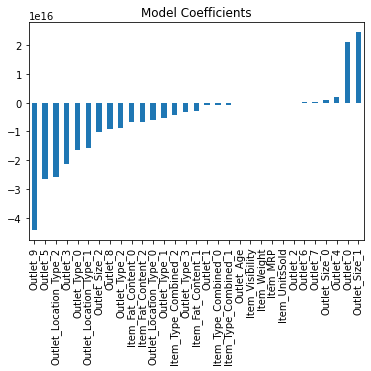

In [45]:
# Linear Regression
lR = LinearRegression(normalize=True)
runModel(lR, xTrain, yTrain, xTest, yTest)
coef1 = pd.Series(lR.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report

CV Score : Mean - 356.4 | Std - 31.45 | Min - 313.1 | Max - 411.6

RMSE : 323



<AxesSubplot:title={'center':'Feature Importances'}>

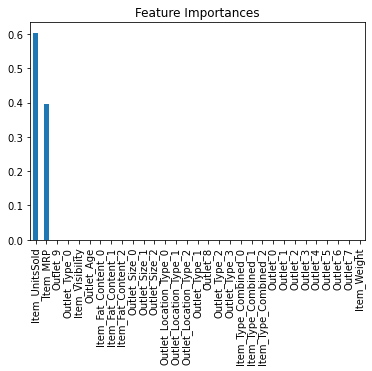

In [46]:
# Decision Tree
dT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
runModel(dT, xTrain, yTrain, xTest, yTest)
coef2 = pd.Series(dT.feature_importances_, predictors).sort_values(ascending=False)
coef2.plot(kind='bar', title='Feature Importances')


Model Report

CV Score : Mean - 333.6 | Std - 39.81 | Min - 289.5 | Max - 410.9

RMSE : 292.7



<AxesSubplot:title={'center':'Feature Importances'}>

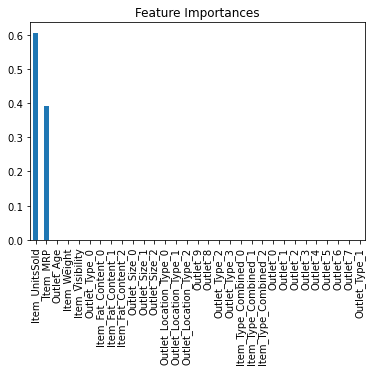

In [47]:
# Random Forest
rF = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
runModel(rF, xTrain, yTrain, xTest, yTest)
coef3 = pd.Series(rF.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')